In [1]:
import tensorflow as tf 
from tensorflow.python.platform import gfile 
import os 
import cv2 
import torch 
from torchvision import datasets, models, transforms 
from torch.autograd import Variable 
import torch.nn as nn 
import torch.nn.functional as F 
import matplotlib.pyplot as plt 
from random import randint
import pandas as pd
from tqdm import tqdm_notebook 
from PIL import Image 
import numpy as np
from glob import glob
import math 
os.environ['CUDA_VISIBLE_DEVICES'] = '7'

In [8]:
with tf.Graph().as_default() as graph:
    with tf.Session(graph=graph) as sess:
        tf.global_variables_initializer().run()
        with gfile.FastGFile('/hdd/sd5/tlc/TCT/Model_pb/efficient_b0_epoch=7.pb', 'rb') as f:
            graph_def = tf.GraphDef()
            graph_def.ParseFromString(f.read())
            tf.import_graph_def(graph_def, name='')
            input_patch = sess.graph.get_tensor_by_name('input:0')
            trainable = sess.graph.get_tensor_by_name('trainable:0')
            prob = sess.graph.get_tensor_by_name('fc_layer/op_to_store:0')
            cam = sess.graph.get_tensor_by_name('cam:0')
            ori_img = np.load('/ssd2/yuyue/TCT_data/20200515_data/val/pos/YFY_data/random_cut/0483fbb2d76e8964c53357a748742e8139ac8ff0_000021_3.npy')
            im_norm = ori_img/255.
            input_ = im_norm[np.newaxis, ...]
            ret_prob, ret_cam = sess.run([prob, cam], feed_dict={input_patch:input_, trainable:False})
            
            
            

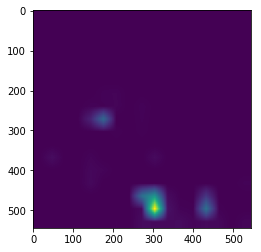

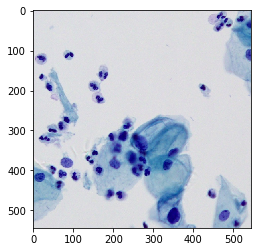

array([[ 0.32959425,  0.67040575]], dtype=float32)

In [10]:
cam_show = cv2.resize(ret_cam[0], (544, 544))
plt.imshow(cam_show)
plt.show()
plt.imshow(ori_img)
plt.show()
ret_prob

In [ ]:
with tf.Graph().as_default() as graph:
    with tf.Session(graph=graph) as sess:
        tf.global_variables_initializer().run()
        with gfile.FastGFile('/hdd/sd2/data/TCT/densenet/model/h5pb_model/test_v3_0413_featuremap/TCT_cls_v3_0413_featuremap.pb', 'rb') as f:
            graph_def = tf.GraphDef()
            graph_def.ParseFromString(f.read())
            tf.import_graph_def(graph_def, name='')
            input_patch = sess.graph.get_tensor_by_name('input_0_2:0')
            output = sess.graph.get_tensor_by_name('output_1_2/Relu:0')
            prob = sess.graph.get_tensor_by_name('output_0_2/Softmax:0')
            ori_img = cv2.imread('/hdd/sd2/data/TCT/densenet/model/h5pb_model/test_v3_0413_featuremap/000126.jpg')
            resize_img = cv2.resize(ori_img, (544*3, 544*2))
            resize_img = cv2.cvtColor(resize_img, cv2.COLOR_BGR2RGB)
            im_norm = resize_img/255.
            #im_norm = cv2.cvtColor(im_norm, cv2.COLOR_BGR2RGB)
            left_x = 0
            batch_count = 0
            input_img = np.zeros(shape=[6, 3, 544, 544], dtype=np.float32)
            for i in range(3):
                left_y = 0
                for j in range(2):
                    img_temp = im_norm[left_y:left_y+544, left_x:left_x+544, :]
                    plt.imshow(img_temp)
                    plt.show()
                    img_temp = np.transpose(img_temp, (2, 0, 1))
                    input_img[batch_count] = img_temp
                    batch_count += 1
                    left_y += 544
                left_x += 544
            ret, ret_prob = sess.run([output, prob], feed_dict={input_patch:input_img})

In [3]:
ret[3][2][4][1]

0.34573707

In [4]:
weights = torch.load('/hdd/sd2/weight.pth')

In [5]:
weights = np.array(weights[1].data.cpu())

In [6]:
weights

array([-0.01561299, -0.00298585,  0.02348932,  0.02259279, -0.00226416,
        0.03427551, -0.02735884,  0.01972886, -0.02583336, -0.00835414,
        0.01723399,  0.02782858,  0.03282514,  0.00920391, -0.02354662,
       -0.04510568,  0.01101122,  0.01532921, -0.0082606 ,  0.00523635,
        0.03338685, -0.0389147 , -0.00627895,  0.02456923,  0.00545233,
       -0.01650095,  0.00283812,  0.00721901,  0.03807244, -0.04154689,
       -0.02495288,  0.01337302, -0.03777356,  0.01755616,  0.01361597,
        0.01748725,  0.03414342, -0.02591175, -0.01127961, -0.01868063,
        0.00773021,  0.01305299,  0.0168353 ,  0.00861462, -0.00011028,
       -0.03986519,  0.02770129, -0.01892077, -0.00432895,  0.00491181,
       -0.00688246, -0.01381424, -0.00723123, -0.02183199, -0.02395059,
        0.00359223,  0.01451759, -0.02779407,  0.04099816,  0.02403903,
        0.00477049,  0.03806553,  0.00738075,  0.03106665, -0.0152431 ,
       -0.0278896 , -0.03801477,  0.03533398, -0.03427853,  0.02

In [11]:
final_res = np.zeros(shape=[6, 17, 17], dtype=np.float32)
ret_temp = ret.copy()
for b in range(6):
    temp_fm = ret_temp[b]
    for idx, w in enumerate(weights):
        temp = temp_fm[idx]
        temp = temp * w        
        temp_fm[idx]= temp
    cam = np.sum(temp_fm, axis=0)
    cam[cam < 0] = 0
    final_res[b] = cam

In [20]:
np.sum(final_res[0])

3.7146602

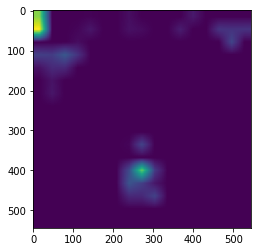

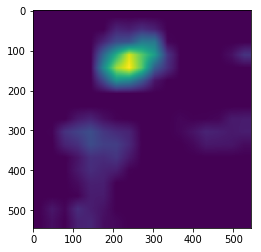

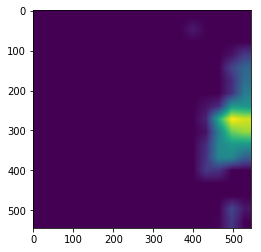

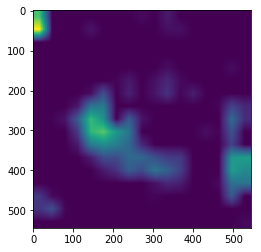

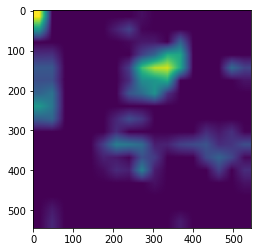

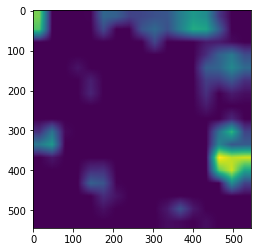

In [14]:
for b in range(6):
    plt.imshow(cv2.resize(final_res[b]*255, (544, 544)))
    plt.show()

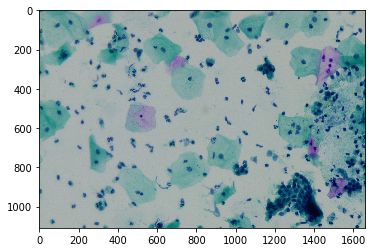

In [26]:
plt.imshow(resize_img)
plt.show()

In [58]:
ret_prob[:, 1]

array([ 0.27149838,  0.50250596,  0.19913892,  0.09921188,  0.24405725,
        0.05921174], dtype=float32)